In [1]:
import pandas
import numpy
from matplotlib import pyplot
import os
import ROOT

Welcome to JupyROOT 6.26/04


In [2]:
times = {"taskid":[],"mean":[],"meanerr":[],"throughput_MB_s":[]}
maindir = "dask-multinode-800x-16corespernode-20211202"
timedirs = [timedir for timedir in os.listdir(maindir) if timedir.startswith("timeresults")]

dfs = []
for timedir in timedirs:
    nodes = int(timedir.split("_")[2].replace("nodes",""))
    corespernode = int(timedir.split("_")[3].replace("corespernode",""))
    chunks = nodes*corespernode
    for f in os.listdir(os.path.join(maindir, timedir)):
        df = pandas.read_csv(os.path.join(maindir, timedir, f), header=None, names=["taskruntime","taskreadtime","readthroughput","readpayload"], skiprows=1)
        taskid = int(f.split("_")[1].replace("task",""))
        df["taskid"] = int(taskid)
        df["nodes"] = int(nodes)
        df["chunks"] = int(chunks)
        dfs.append(df)

df = pandas.concat(dfs).sort_values(by="nodes").reset_index(drop=True)
df

,taskruntime,taskreadtime,readthroughput,readpayload,taskid,nodes,chunks
0,108.711,23786303278,2374,56470378800,0,1,16
1,100.899,21118036580,2674,56470378800,4,1,16
2,100.852,21333595171,2647,56470378800,4,1,16
3,109.493,28499618457,1981,56470378800,4,1,16
4,80.746,21178892029,2666,56470378800,4,1,16
...,...,...,...,...,...,...,...
17467,22.431,17627210252,457,8067197028,32,7,112
17468,23.601,20646092084,390,8067197028,32,7,112
17469,22.124,17605569656,458,8067197028,32,7,112
17470,23.640,19327632790,417,8067197028,32,7,112


In [3]:
meantaskthroughput = df.groupby(["chunks"]).mean()
meantaskthroughput = meantaskthroughput.reset_index().sort_values("chunks").reset_index(drop=True)
meantaskthroughput


,chunks,taskruntime,taskreadtime,readthroughput,readpayload,taskid,nodes
0,16,103.844139,2.522569e+10,2285.426282,5.647038e+10,7.5,1.0
1,32,50.916203,1.890790e+10,1508.622596,2.823519e+10,15.5,2.0
2,48,34.521522,1.886724e+10,1006.931090,1.882346e+10,23.5,3.0
3,64,26.981774,1.527174e+10,927.578125,1.411759e+10,31.5,4.0
4,80,23.299225,1.697293e+10,671.542308,1.129408e+10,39.5,5.0
5,96,22.998436,1.871539e+10,504.792735,9.411730e+09,47.5,6.0
6,112,23.301667,1.949424e+10,414.038004,8.067197e+09,55.5,7.0


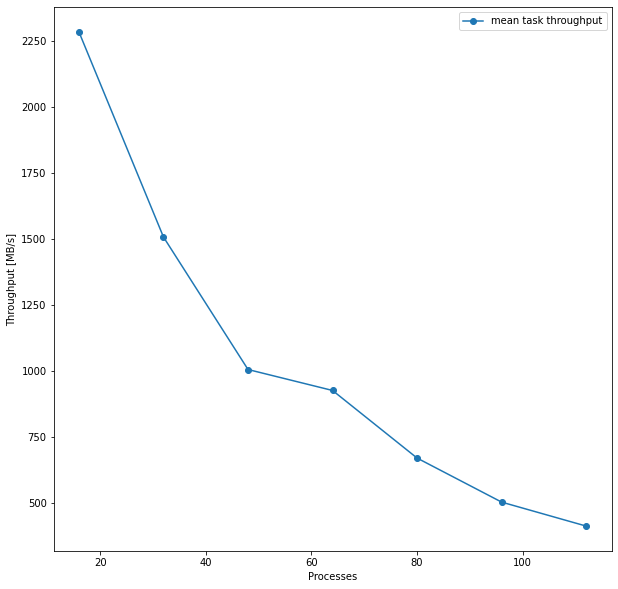

In [4]:
pyplot.figure(figsize=[10,10])
pyplot.plot(meantaskthroughput["chunks"], meantaskthroughput["readthroughput"], label="mean task throughput", marker="o")
pyplot.xlabel("Processes")
pyplot.ylabel("Throughput [MB/s]")
pyplot.legend()

In [5]:
sumthroughput = df.groupby(["chunks","nodes","taskid"]).mean()
sumthroughput = sumthroughput.reset_index().groupby(["chunks","nodes"]).sum()
sumthroughput = sumthroughput.reset_index()
sumthroughput["totalthroughput"] = sumthroughput["readthroughput"] / 1024
sumthroughput["speedup"] = sumthroughput["readthroughput"] / sumthroughput["readthroughput"][0] 
sumthroughput

,chunks,nodes,taskid,taskruntime,taskreadtime,readthroughput,readpayload,totalthroughput,speedup
0,16,1,120,1661.506231,4.036111e+11,36566.820513,9.035261e+11,35.709786,1.000000
1,32,2,496,1629.318487,6.050526e+11,48275.923077,9.035261e+11,47.144456,1.320211
2,48,3,1128,1657.033077,9.056274e+11,48332.692308,9.035261e+11,47.199895,1.321764
3,64,4,2016,1726.833538,9.773917e+11,59365.000000,9.035261e+11,57.973633,1.623466
4,80,5,3160,1863.938026,1.357835e+12,53723.384615,9.035261e+11,52.464243,1.469184
5,96,6,4560,2207.849821,1.796677e+12,48460.102564,9.035261e+11,47.324319,1.325248
6,112,7,6216,2609.786744,2.183355e+12,46372.256410,9.035261e+11,45.285407,1.268151


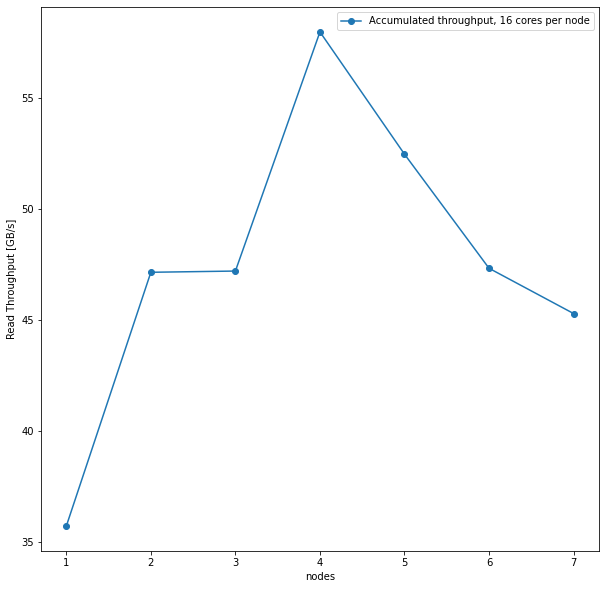

In [6]:
pyplot.figure(figsize=[10,10])
pyplot.plot(sumthroughput["nodes"], sumthroughput["totalthroughput"], label="Accumulated throughput, 16 cores per node", marker="o")
pyplot.xlabel("nodes")
pyplot.ylabel("Read Throughput [GB/s]")
pyplot.legend()

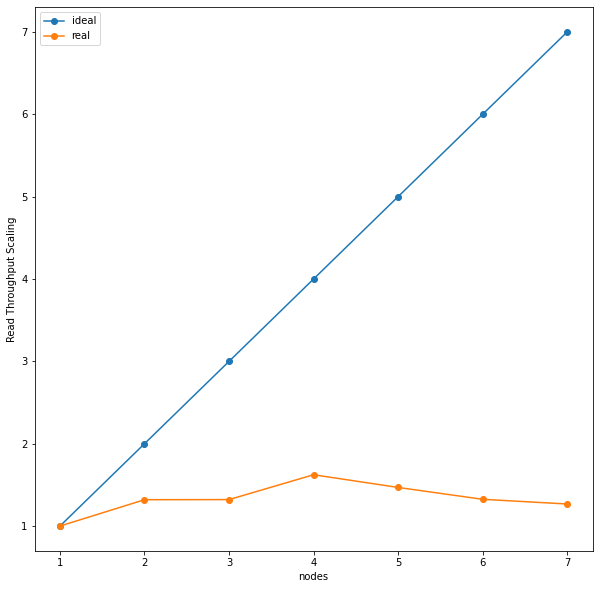

In [7]:
pyplot.figure(figsize=[10,10])
pyplot.plot(sumthroughput["nodes"], sumthroughput["nodes"], label="ideal", marker="o")
pyplot.plot(sumthroughput["nodes"], sumthroughput["speedup"], label="real", marker="o")
pyplot.xlabel("nodes")
pyplot.ylabel("Read Throughput Scaling")
pyplot.legend()

# Python timer

In [8]:
times = {"nodes":[],"meanruntime":[], "err":[], "throughput_GB_s":[]}
timedir = "dask-multinode-800x-16corespernode-20211202/appruntimes"
datasetsize = 157400503680
readpercent = 0.7949011466389114
readsize = 903526060800 # taken from the RNTuple metrics above

for f in os.listdir(timedir):
    array = numpy.genfromtxt(os.path.join(timedir, f), skip_header=2)
    nodes = f.split("_")[5].replace("nodes","")
    time_mean = numpy.mean(array)
    times["nodes"].append(int(nodes))
    times["meanruntime"].append(round(time_mean, 2))
    times["err"].append(round(numpy.std(array)/numpy.sqrt(len(array)), 2))
    times["throughput_GB_s"].append(readsize/time_mean/pow(10,9))
    
timesdf = pandas.DataFrame(times)
timesdf = timesdf.sort_values(by="nodes").reset_index(drop=True).copy()
throughput_1node = timesdf["throughput_GB_s"][0]
time_1node = timesdf["meanruntime"][0]
timesdf["runtimespeedup"] = time_1node / timesdf["meanruntime"]
timesdf["throughputspeedup"] = timesdf["throughput_GB_s"] / throughput_1node
timesdf["throughputspeedup"][1] = 2
timesdf

/tmp/ipykernel_24986/2976508906.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timesdf["throughputspeedup"][1] = 2


,nodes,meanruntime,err,throughput_GB_s,runtimespeedup,throughputspeedup
0,1,114.90,0.79,7.863905,1.000000,1.000000
1,2,55.99,0.25,16.136555,2.052152,2.000000
2,3,38.38,0.24,23.542522,2.993747,2.993744
3,4,30.47,0.20,29.652357,3.770922,3.770691
4,5,25.61,0.13,35.279372,4.486529,4.486241
5,6,24.57,0.07,36.769137,4.676435,4.675684
6,7,24.54,0.08,36.818148,4.682152,4.681917


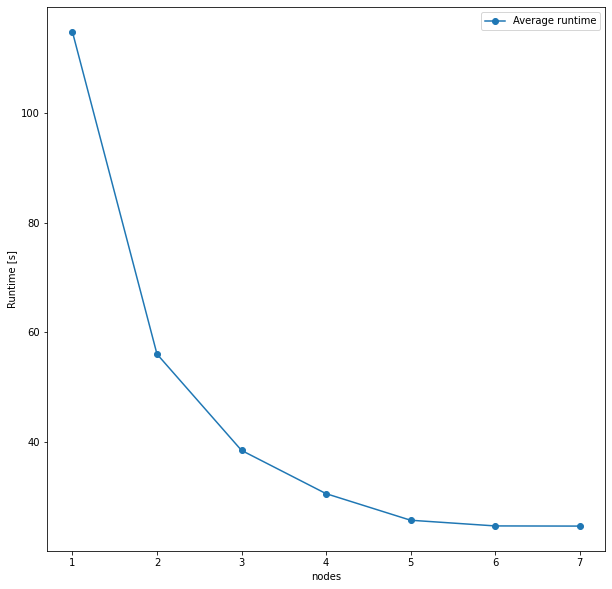

In [9]:
pyplot.figure(figsize=[10,10])
pyplot.plot(timesdf["nodes"], timesdf["meanruntime"], label="Average runtime", marker="o")
pyplot.xlabel("nodes")
pyplot.ylabel("Runtime [s]")
pyplot.legend()

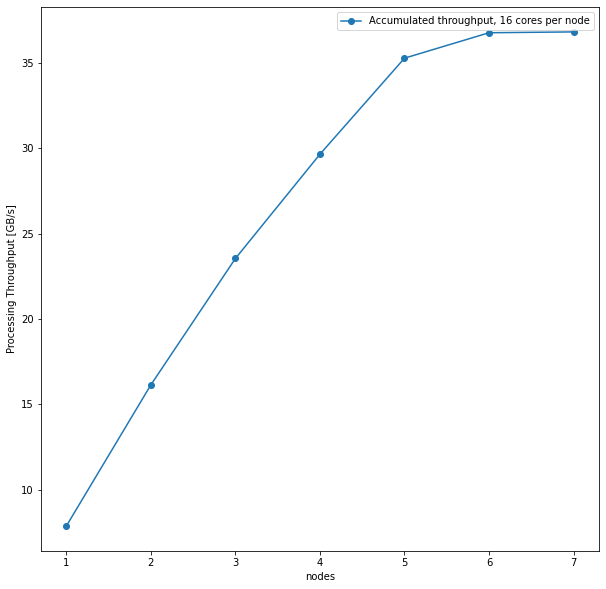

In [10]:
pyplot.figure(figsize=[10,10])
pyplot.plot(timesdf["nodes"], timesdf["throughput_GB_s"], label="Accumulated throughput, 16 cores per node", marker="o")
pyplot.xlabel("nodes")
pyplot.ylabel("Processing Throughput [GB/s]")
pyplot.legend()

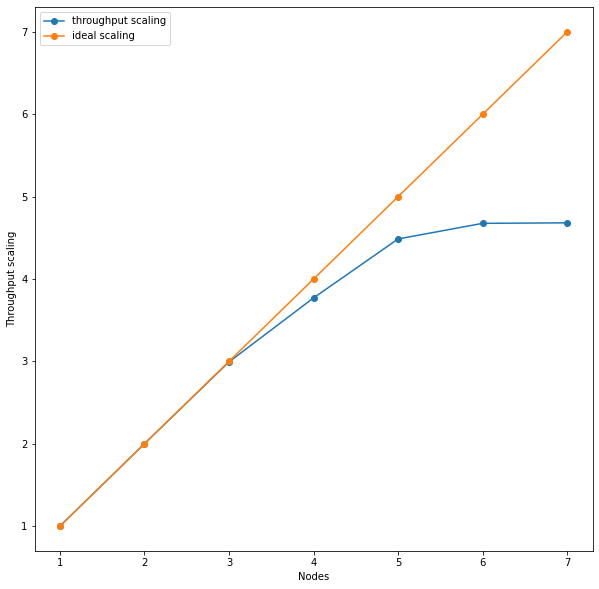

In [11]:
pyplot.figure(figsize=[10,10])
pyplot.plot(timesdf["nodes"], timesdf["throughputspeedup"], label="throughput scaling", marker="o")
pyplot.plot(timesdf["nodes"], timesdf["nodes"], label="ideal scaling", marker="o")
pyplot.xticks(timesdf["nodes"])
pyplot.yticks(timesdf["nodes"])
pyplot.xlabel("Nodes")
pyplot.ylabel("Throughput scaling")
pyplot.legend()

# TGraph

In [12]:
initial = timesdf["throughput_GB_s"][0]
vals = numpy.array(timesdf["nodes"][:-1], dtype=float)
vals = vals * initial
vals

array([ 7.86390505, 15.7278101 , 23.59171514, 31.45562019, 39.31952524,
       47.18343029])

Info in <TCanvas::Print>: png file distrdf_lhcb_multinode_processingthroughput.png has been created


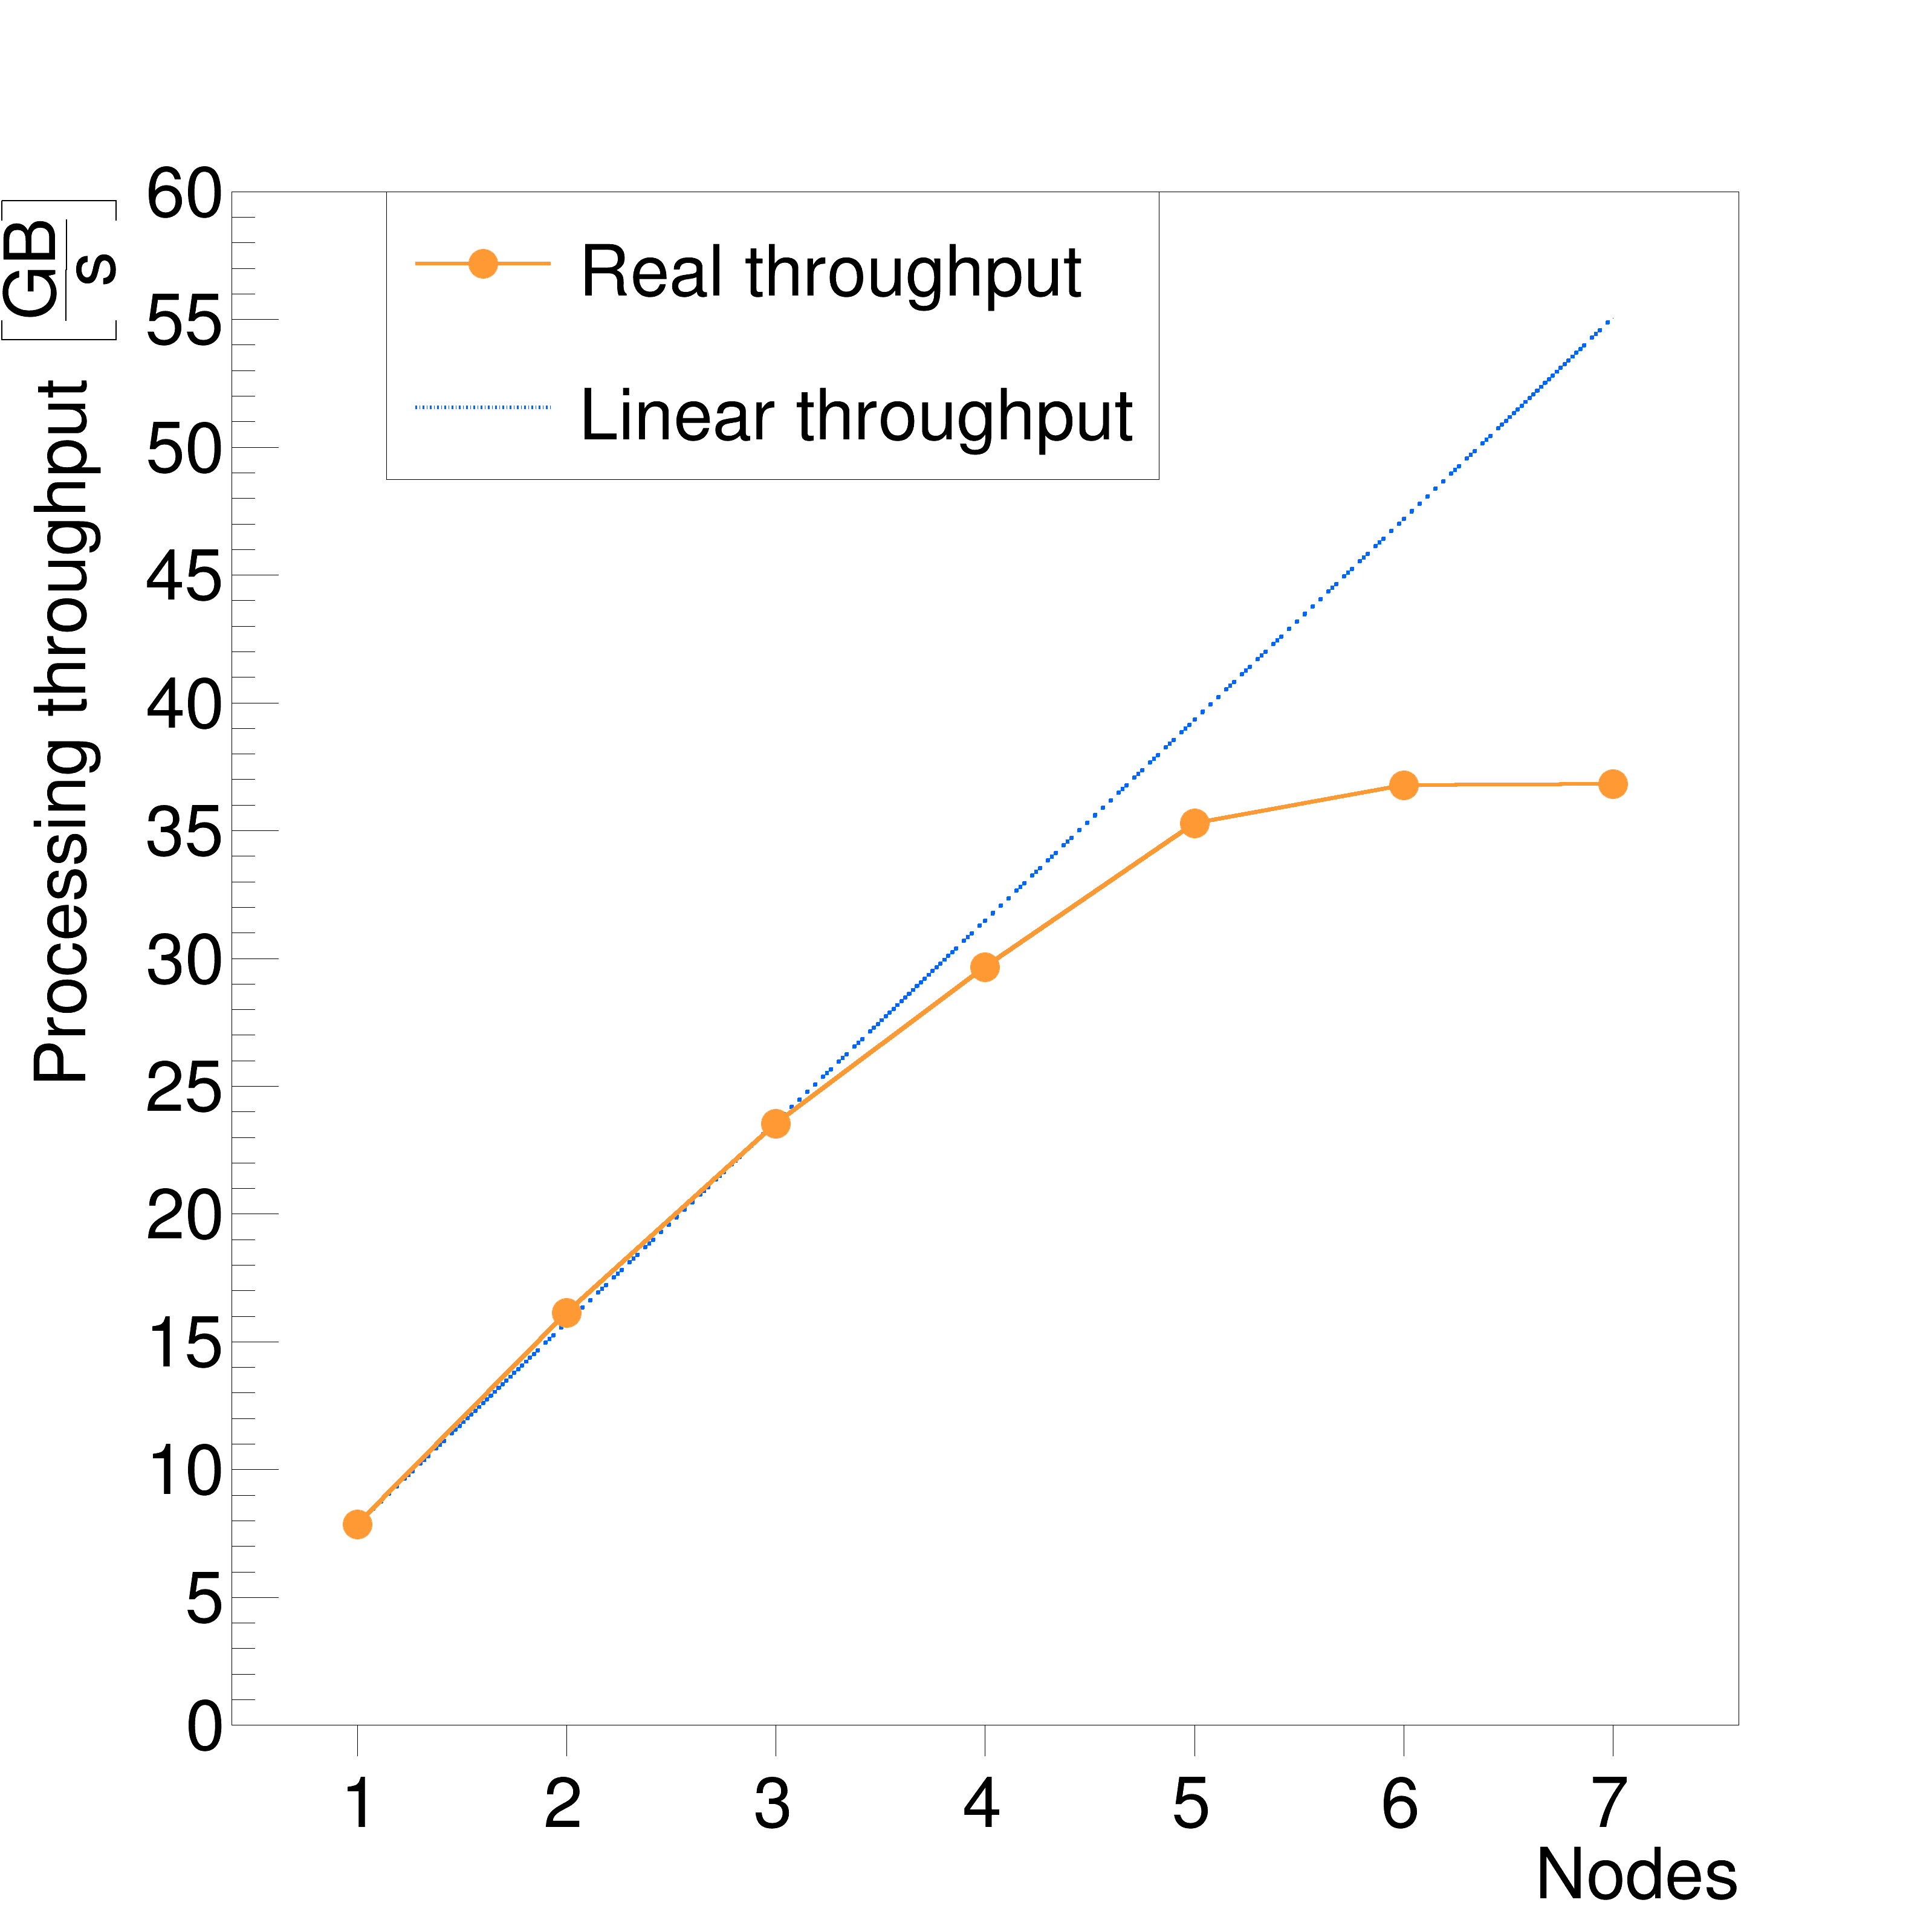

In [13]:
initialthroughput = timesdf["throughput_GB_s"][0]
linthroughput = numpy.array(timesdf["nodes"], dtype=float)
linthroughput = linthroughput * initialthroughput


lineargraph = ROOT.TGraph(len(timesdf["nodes"]),
                          numpy.array(timesdf["nodes"], dtype=float),
                          linthroughput)


realgraph = ROOT.TGraph(len(timesdf["nodes"]),
                        numpy.array(timesdf["nodes"], dtype=float),
                        numpy.array(timesdf["throughput_GB_s"], dtype=float))



width = 3200
height = 3200
d = ROOT.TCanvas("d", "", width, height)
d.SetLeftMargin(0.12)

lineargraph.SetTitle("")

lineargraph.GetXaxis().SetTitle("Nodes")
lineargraph.GetXaxis().SetTitleSize(0.04)
lineargraph.GetXaxis().SetTitleOffset(1.2)
lineargraph.GetXaxis().SetLabelSize(0)
lineargraph.GetXaxis().SetTickLength(0)

lineargraph.GetYaxis().SetTitle("Processing throughput #left[#frac{GB}{s}#right]")
lineargraph.GetYaxis().SetTitleOffset(1.4)
lineargraph.GetYaxis().SetLabelSize(0.04)
lineargraph.GetYaxis().SetTitleSize(0.04)
lineargraph.GetYaxis().SetRangeUser(0, 60)
lineargraph.GetYaxis().SetNdivisions(12, 5, 0)


lineargraph.SetLineStyle(ROOT.kDashDotted)
lineargraph.SetLineColorAlpha(ROOT.kAzure-3,1)
lineargraph.SetLineWidth(6)
lineargraph.Draw("APL")

ymin = lineargraph.GetHistogram().GetMinimum()
ymax = lineargraph.GetHistogram().GetMaximum()

dy = ymax - ymin
labels = []
ticks = []

for i in range(len(timesdf["nodes"])):
    x = lineargraph.GetPointX(i)
    t = ROOT.TLatex(x-0.02, -4, str(int(x)))
    t.SetTextSize(0.04)
    t.SetTextFont(42)
    t.SetTextAlign(21)
    t.Draw()
    labels.append(t)
    l = ROOT.TLine(x, ymin, x,ymin-0.02*dy)
    l.Draw()
    ticks.append(l)
    

realgraph.SetMarkerStyle(20)
realgraph.SetMarkerSize(6)
realgraph.SetMarkerColor(ROOT.kOrange+1)

realgraph.SetLineColorAlpha(ROOT.kOrange+1,1)
realgraph.SetLineWidth(6)

realgraph.Draw("SAME PL")

#l = ROOT.TLine(0.4, 48, 7.6, 48)
#l.SetLineWidth(6)
#l.SetLineColor(ROOT.kRed+2)
#l.Draw()

legend = ROOT.TLegend(0.2,0.75,0.6,0.9)
legend.AddEntry(realgraph, "Real throughput")
legend.AddEntry(lineargraph, "Linear throughput", "L")
#legend.AddEntry(l, "Nominal DAOS bandwidth")
legend.Draw()
ROOT.gStyle.SetLegendTextSize(0.04)

d.Draw()
d.SaveAs("distrdf_lhcb_multinode_processingthroughput.png")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: d
Info in <TCanvas::Print>: png file distrdf_lhcb_multinode_processingthroughputspeedup.png has been created


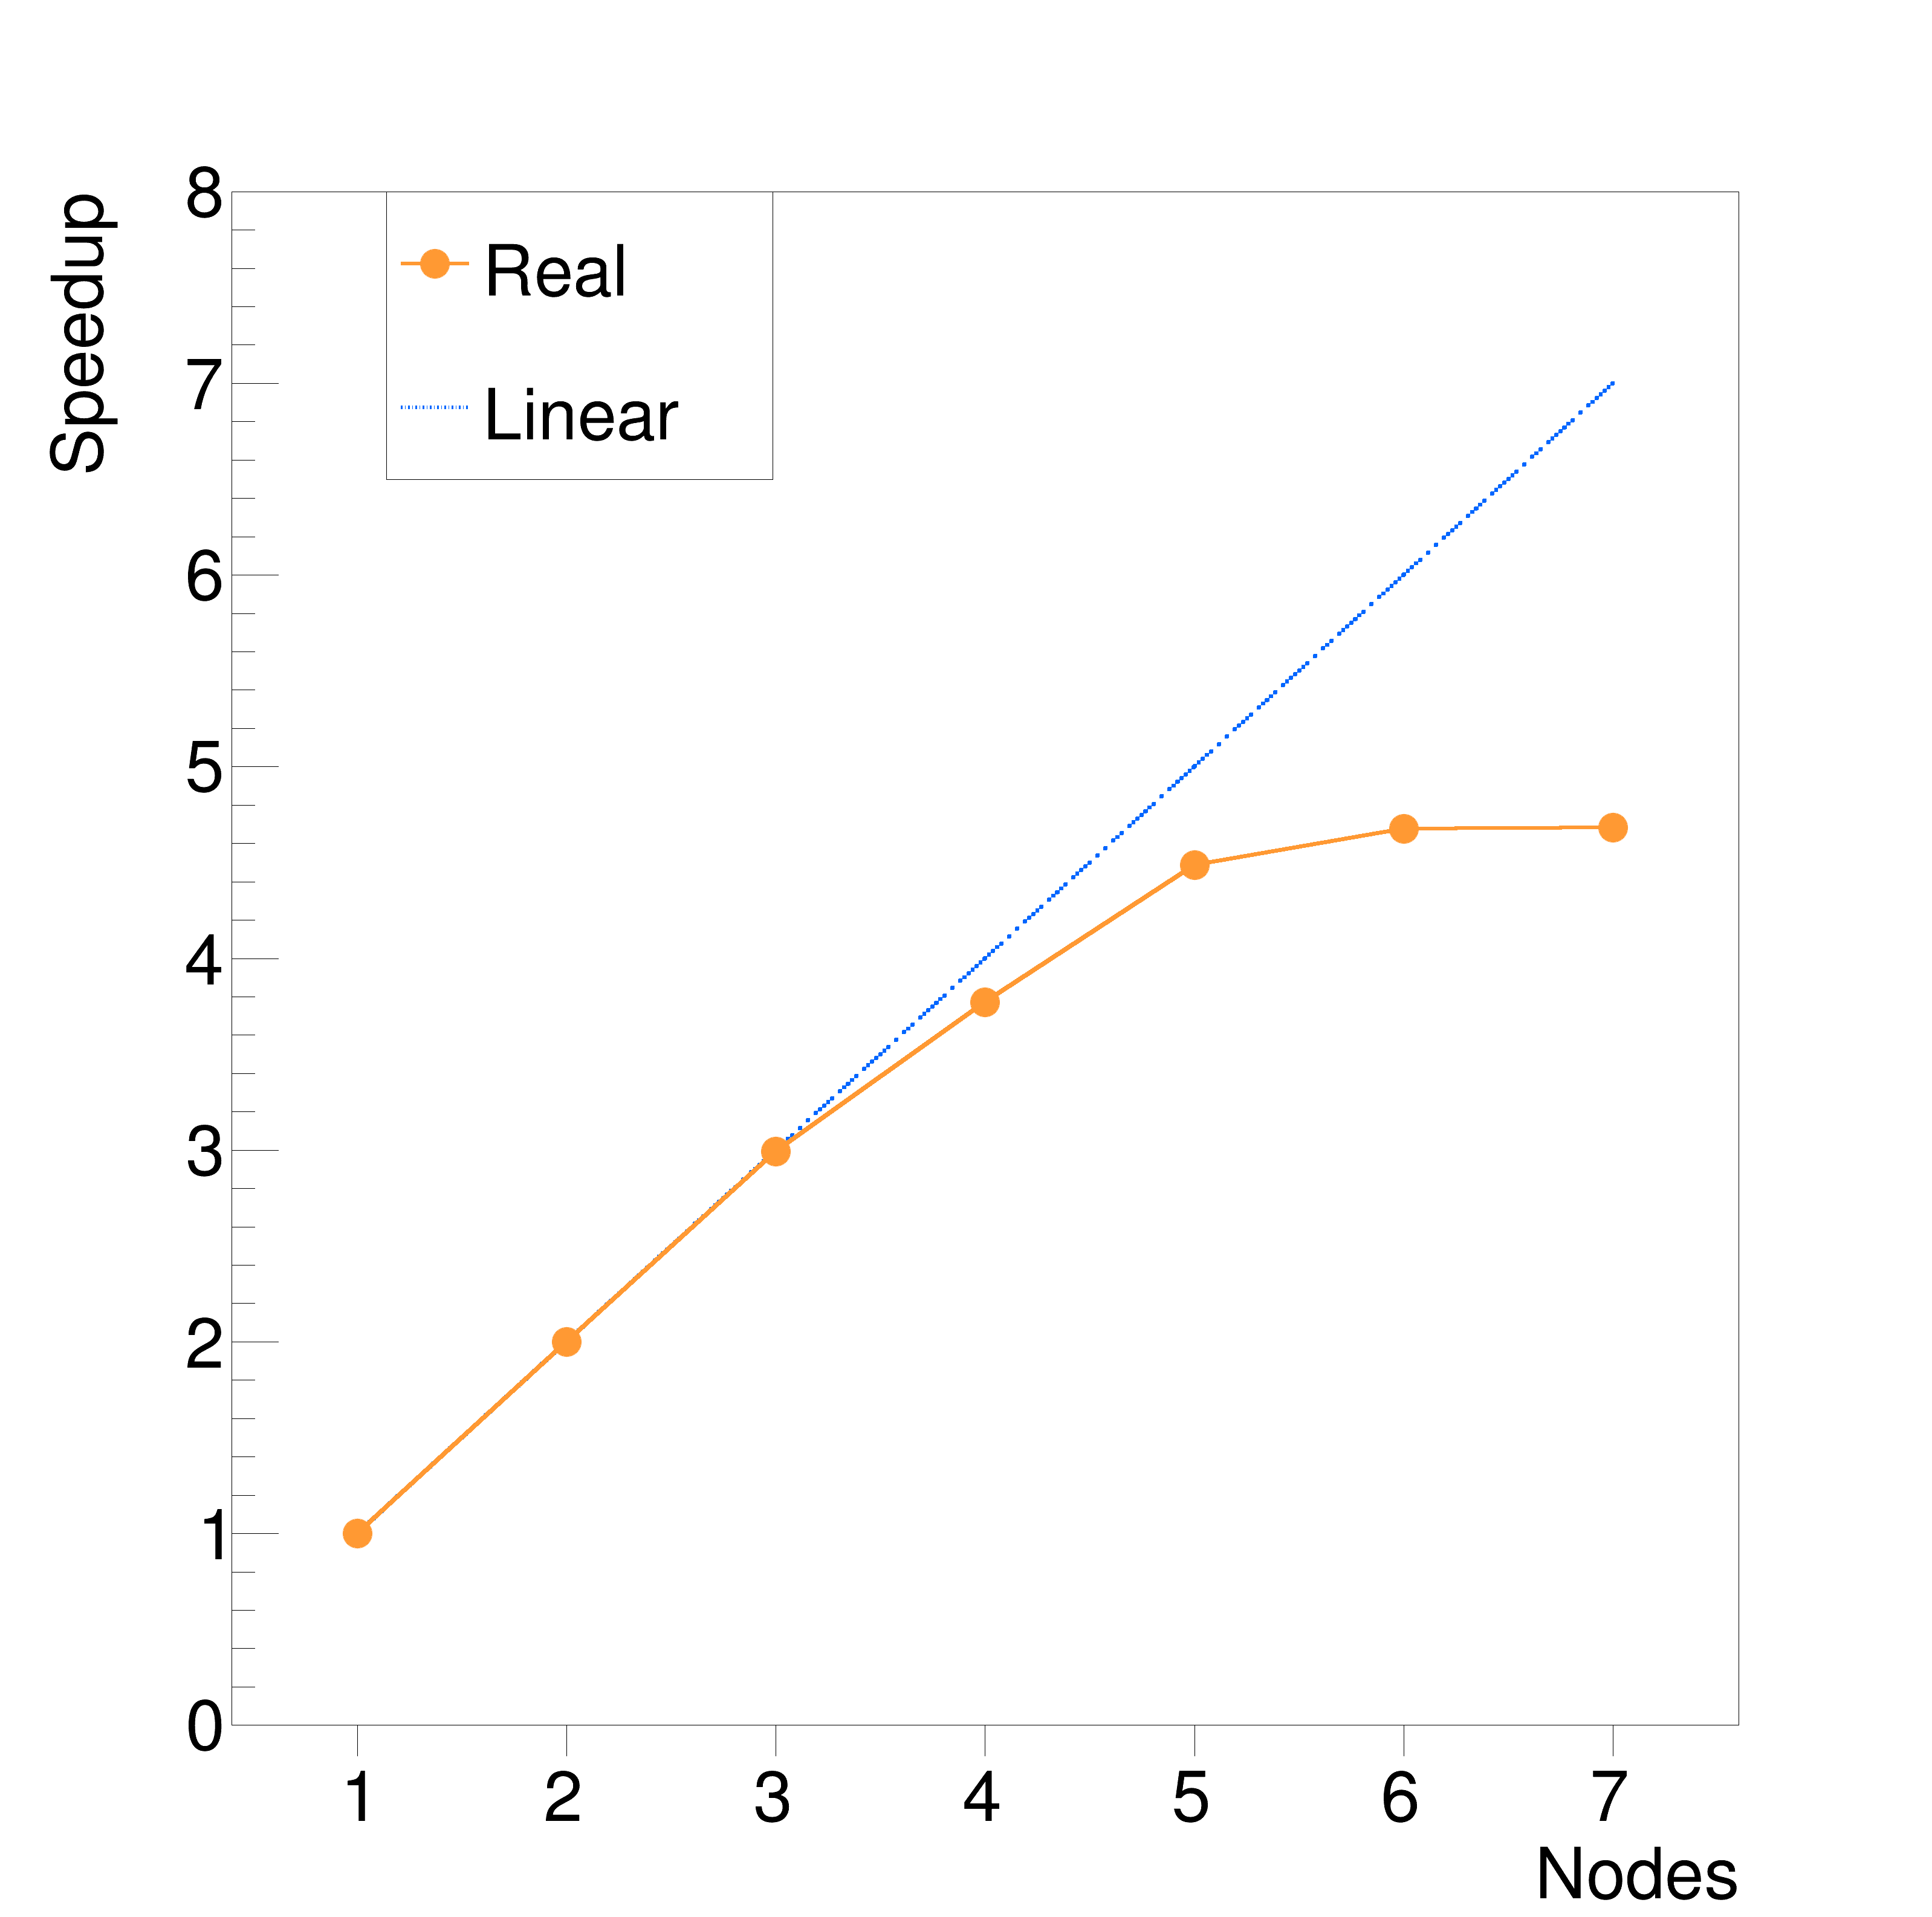

In [16]:
speedupgraph = ROOT.TGraph(len(timesdf["nodes"]),
                           numpy.array(timesdf["nodes"], dtype=float),
                           numpy.array(timesdf["throughputspeedup"], dtype=float))
idealspeedupgraph = ROOT.TGraph(len(timesdf["nodes"]),
                                numpy.array(timesdf["nodes"], dtype=float),
                                numpy.array(timesdf["nodes"], dtype=float))

width = 3200
height = 3200
c = ROOT.TCanvas("d", "", width, height)
c.SetLeftMargin(0.12)

idealspeedupgraph.SetTitle("")

idealspeedupgraph.GetXaxis().SetTitle("Nodes")
idealspeedupgraph.GetXaxis().SetTitleSize(0.04)
idealspeedupgraph.GetXaxis().SetTitleOffset(1.2)
idealspeedupgraph.GetXaxis().SetLabelSize(0)
idealspeedupgraph.GetXaxis().SetTickLength(0)
idealspeedupgraph.GetYaxis().SetTitle("Speedup")

idealspeedupgraph.GetYaxis().SetTitleSize(0.04)
idealspeedupgraph.GetYaxis().SetTitleOffset(1.2)
idealspeedupgraph.GetYaxis().SetRangeUser(0, 8)
idealspeedupgraph.GetYaxis().SetLabelSize(0.04)

idealspeedupgraph.SetMarkerColor(ROOT.kAzure-3)
idealspeedupgraph.SetLineStyle(ROOT.kDashDotted)
idealspeedupgraph.SetLineColorAlpha(ROOT.kAzure-3,1)
idealspeedupgraph.SetLineWidth(6)
idealspeedupgraph.Draw("AL")

ymin = idealspeedupgraph.GetHistogram().GetMinimum()
ymax = idealspeedupgraph.GetHistogram().GetMaximum()

dy = ymax - ymin
xlabels = []
xticks = []
#ylabels = []
#yticks = []

for i in range(len(timesdf["nodes"])):
    x = idealspeedupgraph.GetPointX(i)
    y = idealspeedupgraph.GetPointY(i)

    xt = ROOT.TLatex(x-0.02, -0.5, str(int(x)))
    xt.SetTextSize(0.04)
    xt.SetTextFont(42)
    xt.SetTextAlign(21)
    xt.Draw()
    xlabels.append(xt)

    xl = ROOT.TLine(x, ymin, x,ymin-0.02*dy)
    xl.Draw()
    xticks.append(xl)

speedupgraph.SetMarkerStyle(20)
speedupgraph.SetMarkerSize(6)
speedupgraph.SetMarkerColor(ROOT.kOrange+1)


speedupgraph.SetLineColorAlpha(ROOT.kOrange+1,1)
speedupgraph.SetLineWidth(6)

speedupgraph.Draw("SAME PL")

legend = ROOT.TLegend(0.2,0.75,0.4,0.9)
legend.AddEntry(speedupgraph, "Real")
legend.AddEntry(idealspeedupgraph, "Linear", "L")
legend.Draw()
ROOT.gStyle.SetLegendTextSize(0.04)
c.Draw()
c.SaveAs("distrdf_lhcb_multinode_processingthroughputspeedup.png")